In [1]:
library(tidyverse)
library(ggplot2)
library(Seurat)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject



In [2]:
rds_file = "/Personal/fuxin/dfuxin/PROJECTS/Bioinfo_Train/results/PYF.rds"
rds = readRDS(rds_file)

In [4]:
data.frame(cluster = c('0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18'),
           celltype = c("Monocyte", "Teffector","Macrophage","Teffector/exhausted","Monocyte",
                        "Teffector/exhausted","Macrophage","Macrophage",
                        "Macrophage","DC","Treg","NK","Monocyte","undetermined","Monocyte",
                        "Tproliferating","Tnaive","Monocyte","undetermined"))->celltype_df

In [5]:
celltype_df$cluster = factor(celltype_df$cluster)

data.frame(cell_ident = Cells(rds),cluster = rds$RNA_snn_res.1)%>%
  left_join(celltype_df)->celltype_df

Joining, by = "cluster"



In [8]:
rownames(celltype_df) <- celltype_df$cell_ident
AddMetaData(rds,celltype_df%>%select(-cluster,-cell_ident))->rds

In [10]:
#整合tag
tag_file = "/Personal/fuxin/dfuxin/PROJECTS/Bioinfo_Train/PYF/04.count_tag/hashing_umi_tag.tsv"
tag_df = read.table(tag_file,header = TRUE)
head(tag_df)
rds <- AddMetaData(rds,tag_df)

,tag1,tag3,tag4,tag5,tag
,<int>,<int>,<int>,<int>,<chr>
AAACATCGAACAACCAAAGACGGA,7,5,42,10,tag4
AAACATCGAACAACCAAATCCGTC,15,8,4,9,Multiplet
AAACATCGAACAACCAACCTCCAA,7,32,8,18,Multiplet
AAACATCGAACAACCAGCTCGGTA,4,15,3,86,tag5
AAACATCGAACCGAGAAATGTTGC,62,4,6,4,tag1
AAACATCGAACCGAGATTCACGCA,524,11,9,9,tag1


In [11]:
rds

An object of class Seurat 
16776 features across 19534 samples within 1 assay 
Active assay: RNA (16776 features, 2000 variable features)
 3 dimensional reductions calculated: pca, tsne, umap

In [13]:
subset(rds, tag %in% c("tag1","tag3","tag4","tag5"))->rds_tag

In [14]:
rds_tag

An object of class Seurat 
16776 features across 13782 samples within 1 assay 
Active assay: RNA (16776 features, 2000 variable features)
 3 dimensional reductions calculated: pca, tsne, umap

Joining, by = "cell_ident"




   Multiplet         tag1         tag3         tag4         tag5 Undetermined 
           0         2409         4548         2917         3908            0 

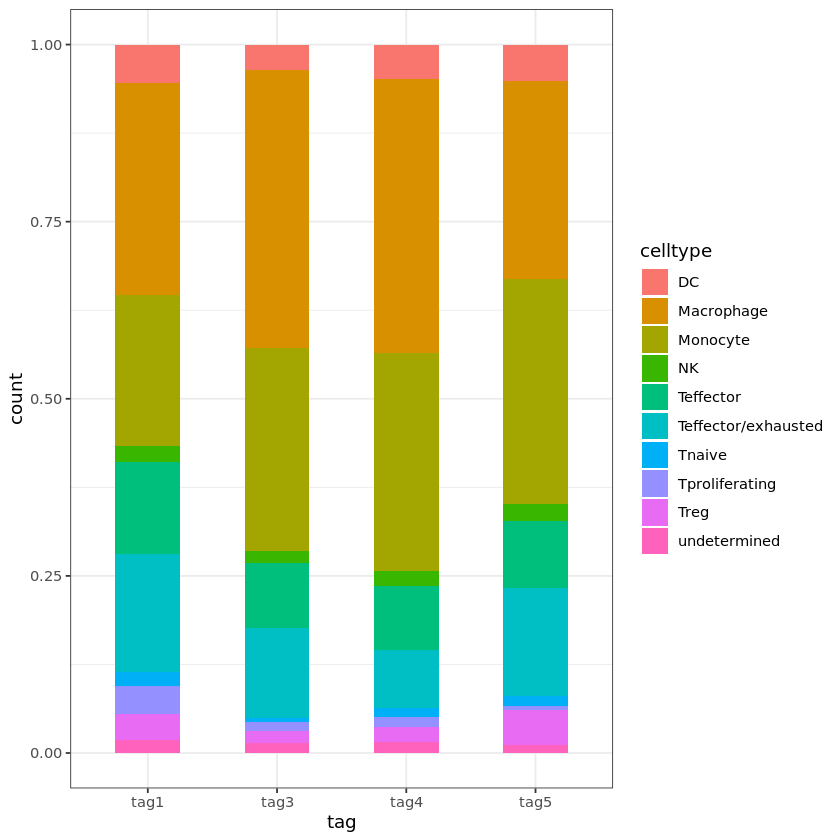

In [15]:
tag_file = "/Personal/fuxin/dfuxin/PROJECTS/Bioinfo_Train/PYF/04.count_tag/hashing_umi_tag.tsv"
tag_df = read.table(tag_file,header = TRUE)

tag_df$cell_ident = rownames(tag_df)
data.frame(cell_ident = Cells(rds_tag), celltype = rds_tag$celltype)%>%
  left_join(tag_df)-> tag_df
rownames(tag_df) <- tag_df$cell_ident
tag_df$tag <- factor(tag_df$tag,levels = c("Multiplet","tag1","tag3","tag4","tag5","Undetermined"))

table(tag_df$tag)

ggplot(tag_df%>%filter(!is.na(tag)),aes(x = tag, fill = celltype))+
  geom_bar(position = "fill",width = 0.5)+
  #scale_fill_manual(values = c("SlateBlue3","DarkOrange","GreenYellow","Purple"))+
  theme_bw()

In [18]:
gene = "Pdcd1"
FeaturePlot(rds_tag, features = gene, split.by = "tag")->p
p_file = "/Personal/fuxin/dfuxin/PROJECTS/Bioinfo_Train/PYF/f.1.pdf"
ggsave(p_file,p,width = 12, height = 3)

In [19]:
rds_ct = subset(rds, celltype %in% c("Teffector", "Teffector/exhausted"))

In [22]:
table(rds_ct$celltype,rds_ct$tag)

                     
                      Multiplet tag1 tag3 tag4 tag5
  Teffector                 925  311  417  264  367
  Teffector/exhausted      1329  401  583  237  595

In [34]:
FindMarkers(rds_ct,ident.1 = "tag1", ident.2  = "tag5", group.by = "tag")->markers

In [37]:
markers%>%filter(p_val_adj<0.05)->markers_flt

In [39]:
genelist = rownames(markers_flt)

In [40]:
#GO
#kegg
#GSEA
#GSVA

library(tidyverse)
library(clusterProfiler)
library(org.Mm.eg.db) #富集分析GO & KEGG
library(msigdbr) #GSEA
library(enrichplot)
library(Seurat)
library(GSVA) # GSVA
library(limma)
library(ggplot2) #画图



clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘pack

In [41]:
#genelist = markers_cluster10$gene
eg <- bitr(genelist, 
           fromType="SYMBOL", 
           toType=c("ENTREZID","ENSEMBL",'SYMBOL'),
           OrgDb=" org.Mm.eg.db")

Loading required package:  org.Mm.eg.db

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ org.Mm.eg.db’”
Loading required package:  org.Mm.eg.db

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ org.Mm.eg.db’”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(genelist, fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL", :
“21.21% of input gene IDs are fail to map...”


In [53]:
markers_flt%>%filter(avg_log2FC<1)->markers_down

In [54]:
dim(markers_down)
head(markers_down)

[1] 29  5

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rgs1,1.361262e-12,0.5462518,0.761,0.640,2.283654e-08
Dusp1,3.754379e-12,0.5026352,0.789,0.663,6.298346e-08
Tnf,1.177094e-11,0.8752603,0.385,0.236,1.974693e-07
Ifi27l2a,3.571763e-11,0.5371961,0.701,0.569,5.991989e-07
mt-Nd4,5.867665e-11,0.5874596,0.787,0.700,9.843595e-07
mt-Nd1,1.225479e-10,0.4628397,0.843,0.760,2.055864e-06


In [42]:
go <- enrichGO(eg$ENTREZID, 
               OrgDb = org.Mm.eg.db, 
               ont='ALL',
               pAdjustMethod = 'BH',
               pvalueCutoff = 0.05, 
               qvalueCutoff = 0.05,
               keyType = 'ENTREZID',
               readable = TRUE)

In [45]:
dotplot(go,showCategory=20,orderBy = "p.adjust")->p
p_file = "/Personal/fuxin/dfuxin/PROJECTS/Bioinfo_Train/go.tag1.5.pdf"
ggsave(p_file,p,width = 8)

Saving 8 x 6.67 in image



In [46]:
# KEGG 富集
kegg <- enrichKEGG(eg$ENTREZID, 
                   organism = 'mmu',
                   keyType = 'kegg', 
                   pvalueCutoff = 0.05,
                   pAdjustMethod = 'BH', 
                   minGSSize = 3,
                   maxGSSize = 500,
                   qvalueCutoff = 0.05,
                   use_internal_data = FALSE)

Reading KEGG annotation online:


Reading KEGG annotation online:




In [55]:
barplot(go,showCategory=20,orderBy = "p.adjust")->p
p_file = "/Personal/fuxin/dfuxin/PROJECTS/Bioinfo_Train/kegg.tag1.5.pdf"
ggsave(p_file,p,width = 8)

Saving 8 x 6.67 in image



In [57]:
#拟时序分析
library(tidyverse)
library(Seurat)
library(monocle)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: VGAM

Loading required package: splines


Attaching package: ‘VGAM’


The following object is masked from ‘package:tidyr’:

    fill


Loading required package: DDRTree

Loading required package: irlba



In [58]:
rds_t = subset(rds, celltype == "Teffector/exhausted")

In [60]:
# Extract data, phenotype data, and feature data from the SeuratObject
data <- as(as.matrix(rds_t@assays$RNA@counts), 'sparseMatrix')
pd <- new('AnnotatedDataFrame', data = rds_t@meta.data)
fData <- data.frame(gene_short_name = row.names(data), row.names = row.names(data))
fd <- new('AnnotatedDataFrame', data = fData)
HSMM <- newCellDataSet(data,
                              phenoData = pd,
                              featureData = fd,
                              lowerDetectionLimit = 0.5,
                              expressionFamily = negbinomial.size())

In [61]:
## normalization
HSMM <- estimateSizeFactors(HSMM)
HSMM <- estimateDispersions(HSMM)
#Filtering low-quality cells
HSMM <- detectGenes(HSMM, min_expr = 3 )

Warning message:
“`group_by_()` was deprecated in dplyr 0.7.0.
Please use `group_by()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”
Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning mes

In [62]:
HSMM

CellDataSet (storageMode: environment)
assayData: 16776 features, 3145 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: AAACATCGAACAACCAGCTCGGTA AAACATCGAACGTGATACAGATTC ...
    TTCACGCATCCGTCTACACCTTAC (3145 total)
  varLabels: orig.ident nCount_RNA ... num_genes_expressed (17 total)
  varMetadata: labelDescription
featureData
  featureNames: Gnai3 Cdc45 ... AC147806.2 (16776 total)
  fvarLabels: gene_short_name num_cells_expressed
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [63]:
expressed_genes <- row.names(subset(fData(HSMM),num_cells_expressed >= 10))

In [64]:
#Clustering cells without marker genes 
disp_table <- dispersionTable(HSMM)
unsup_clustering_genes <- subset(disp_table, mean_expression >= 0.1)
HSMM <- setOrderingFilter(HSMM, unsup_clustering_genes$gene_id)

HSMM <- reduceDimension(HSMM, max_components = 2, num_dim = 10,
                         reduction_method = 'tSNE', verbose = T)

Remove noise by PCA ...

Reduce dimension by tSNE ...



In [65]:
#Step 1: choosing genes that define progress
diff_test_res <- differentialGeneTest(HSMM[expressed_genes,],
                                      fullModelFormulaStr = "~percent.mito")
ordering_genes <- row.names (subset(diff_test_res, qval < 0.01))
HSMM <- setOrderingFilter(HSMM, ordering_genes)

In [66]:
#Trajectory step 2: reduce data dimensionality  
HSMM <- reduceDimension(HSMM, max_components = 2,
                            method = 'DDRTree')

In [67]:
#Trajectory step 3: order cells along the trajectory  
HSMM <- orderCells(HSMM)

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class(projection) != "matrix") projection <- as.matrix(projection):
“the condition has length > 1 and only the first element will be used”
Warning message in if (class

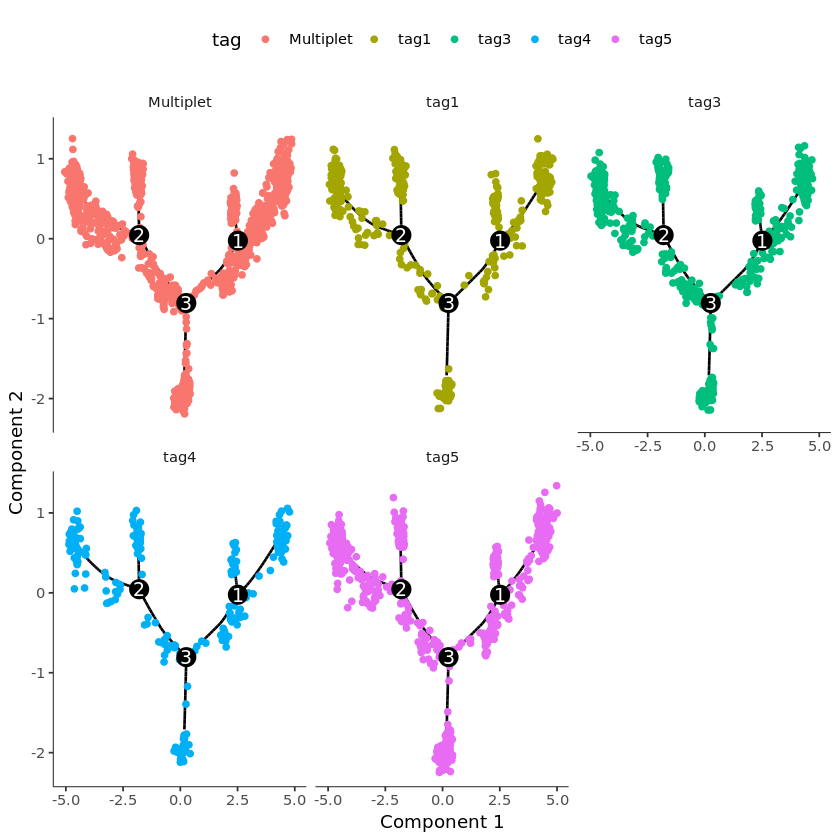

In [70]:
plot_cell_trajectory(HSMM, color_by = "tag")+ facet_wrap(~`tag`, nrow = 2)

In [79]:
#TCR Plot
tcr_file = "/Personal/fuxin/dfuxin/PROJECTS/Bioinfo_Train/matched_productive_contig_annotations.csv"
tcr_df = readr::read_csv(tcr_file)

Rows: 1368 Columns: 31

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (23): barcode, contig_id, chain, v_gene, d_gene, j_gene, c_gene, fwr1, f...
dbl  (4): length, reads, umis, exact_subclonotype_id
lgl  (4): is_cell, high_confidence, full_length, productive


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [72]:
head(tcr_df)

barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,⋯,fwr3_nt,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id
<chr>,<lgl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
CCTAATCCCAACCACAATTGGCTC,TRUE,CCTAATCCCAACCACAATTGGCTC_contig_1,TRUE,634,TRA,TRAV6-6,NA,TRAJ31,TRAC,⋯,GGAAGCAGCAGAGGGTTTGAAGCCACATACAATAAAGAAGCCACCTCCTTCCACTTGCAGAAAGCCTCAGTGCAAGAGTCAGACTCGGCTGTGTACTAC,CALGDGNRIFF,TGTGCTCTGGGTGATGGTAACAGAATCTTCTTT,GDGTQLVVKP,GGTGATGGGACGCAGCTGGTGGTGAAGCCCA,18053,4,clonotype185,clonotype185_consensus_2,1
CCTAATCCCAACCACAATTGGCTC,TRUE,CCTAATCCCAACCACAATTGGCTC_contig_2,TRUE,635,TRB,TRBV13-3,TRBD1,TRBJ1-2,TRBC1,⋯,ACGGAGAAAGGAGATATCCCTGATGGGTACAAGGCCTCCAGACCAAGCCAAGAGAATTTCTCTCTCATTCTGGAGTTGGCTTCCCTTTCTCAGACAGCTGTATATTTC,CASSSGTGGLDYTF,TGTGCCAGCAGTTCCGGGACAGGGGGCCTCGACTACACCTTC,GSGTRLLVI,GGCTCAGGGACCAGGCTTTTGGTAATAG,665,4,clonotype185,clonotype185_consensus_1,1
AAGGACACAATCCGTCACCACTGT,TRUE,AAGGACACAATCCGTCACCACTGT_contig_1,TRUE,749,TRA,TRAV6N-7,NA,TRAJ34,TRAC,⋯,GGAAGCAGCAGAGGGTTTGAAGCCACATACAATAAAGAAGCCACCTCCTTCCACTTGCAGAAAGCCTCAGTGCAAGAGTCAGACTCGGCTGTGTACTAC,CALSDGPNTDKVVF,TGCGCTCTGAGTGACGGGCCCAATACCGACAAAGTCGTCTTT,GTGTRLQVSP,GGAACAGGGACCAGATTACAAGTCTCACCAA,74058,7,clonotype342,clonotype342_consensus_1,1
GAGTTAGCGTCTGTCACGAACTTA,TRUE,GAGTTAGCGTCTGTCACGAACTTA_contig_1,TRUE,558,TRA,TRAV12-3,NA,TRAJ40,TRAC,⋯,ACCGAGCACCAAGGGTTCCACGCCACTCTCCATAAGAGCAGCAGCTCCTTCCATCTGCAGAAGTCCTCAGCGCAGCTGTCAGACTCTGCCCTGTACTAC,CALRTGNYKYVF,TGTGCTTTGAGAACAGGAAACTACAAATACGTCTTT,GAGTRLKVIA,GGAGCAGGTACCAGACTGAAGGTTATAGCAC,9048,3,clonotype236,clonotype236_consensus_1,1
CTGTAGCCTGGTGGTAGATAGACA,TRUE,CTGTAGCCTGGTGGTAGATAGACA_contig_1,TRUE,543,TRA,TRAV12D-2,NA,TRAJ31,TRAC,⋯,ACCGAGCACCAAGGGTTCTACGCCACTCTCCATAAGAGCAGCAGCTCCTTCCATCTGCAGAAGTCCTCAGTGCAGCTGTCAGACTCTGCCCTGTACTTC,CALSDHNNNRIFF,TGTGCTTTGAGTGATCACAACAATAACAGAATCTTCTTT,GDGTQLVVKP,GGTGATGGGACGCAGCTGGTGGTGAAGCCCA,38418,5,clonotype166,clonotype166_consensus_1,1
ACATTGGCAAGGACACAATCCGTC,TRUE,ACATTGGCAAGGACACAATCCGTC_contig_1,TRUE,829,TRA,TRAV7N-4,NA,TRAJ11,TRAC,⋯,AAGAAAGAAGGCAGATTCACAGCTCACCTCAATAAGGCCAGCCTGCATGTTTCCCTGCACATCAGAGACTCCCAGCCCAGTGACTCTGCTCTCTACTTC,CAASDSGYNKLTF,TGTGCAGCTAGTGACTCGGGATACAACAAACTCACTTTT,GKGTVLLVSP,GGAAAGGGCACGGTACTTCTAGTCTCTCCAG,4433,3,clonotype4,clonotype4_consensus_2,1


In [73]:
data.frame(cell_ident = Cells(rds), celltype = rds$celltype, tag = rds$tag) -> ddf

In [80]:
tcr_df%>%
    dplyr::select(barcode,raw_clonotype_id)%>%
    left_join(ddf, by = c("barcode" = "cell_ident"))->tcr_df

In [85]:
head(tcr_df)

barcode,raw_clonotype_id,celltype,tag
<chr>,<chr>,<chr>,<chr>
CCTAATCCCAACCACAATTGGCTC,clonotype185,Teffector/exhausted,tag4
CCTAATCCCAACCACAATTGGCTC,clonotype185,Teffector/exhausted,tag4
AAGGACACAATCCGTCACCACTGT,clonotype342,Teffector/exhausted,tag5
GAGTTAGCGTCTGTCACGAACTTA,clonotype236,Teffector/exhausted,tag4
CTGTAGCCTGGTGGTAGATAGACA,clonotype166,Treg,tag1
ACATTGGCAAGGACACAATCCGTC,clonotype4,Teffector/exhausted,Multiplet


In [92]:
tcr_df%>%
    dplyr::select(-celltype)%>%
    group_by(raw_clonotype_id,tag)%>%
    summarise(count = n())%>%
    ungroup()->gdf

`summarise()` has grouped output by 'raw_clonotype_id'. You can override using the `.groups` argument.



In [93]:
head(gdf)

raw_clonotype_id,tag,count
<chr>,<chr>,<int>
clonotype1,Multiplet,31
clonotype1,tag1,4
clonotype1,tag3,52
clonotype1,tag4,9
clonotype1,tag5,6
clonotype10,Multiplet,8


In [101]:
gdf%>%
    filter(tag %in% c("tag1","tag3","tag4","tag5"))->gdf

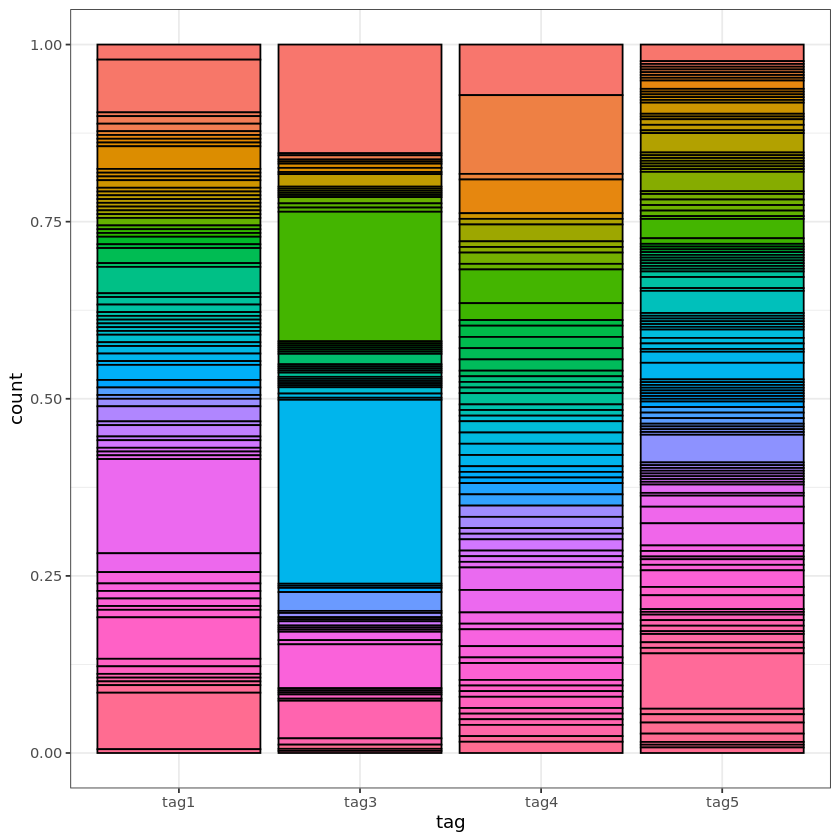

In [104]:
ggplot(gdf, aes(x = tag,y = count, fill = raw_clonotype_id))+
geom_bar(color = "black",stat = "identity", position = "fill")+
theme_bw()+
theme(
    legend.position="none"
)

In [83]:
head(gdf)

barcode,raw_clonotype_id,celltype,tag
<chr>,<chr>,<chr>,<chr>
CTGTAGCCTGGTGGTAGATAGACA,clonotype166,Treg,tag1
CTGAGCCAGTCGTAGATATCAGCA,clonotype9,Teffector/exhausted,tag1
CGACTGGACGAACTTACCATCCTC,clonotype10,Teffector/exhausted,tag1
CGACTGGACGAACTTACCATCCTC,clonotype10,Teffector/exhausted,tag1
ACCTCCAAAGATCGCACAAGGAGC,clonotype80,Teffector/exhausted,tag1
ACCTCCAAAGATCGCACAAGGAGC,clonotype80,Teffector/exhausted,tag1


In [84]:
table(gdf$raw_clonotype_id)


  clonotype1  clonotype10 clonotype103 clonotype105 clonotype106 clonotype115 
           4           14            1            2            2            1 
 clonotype12 clonotype121 clonotype127  clonotype13 clonotype131 clonotype132 
           1            1            1            6            1            1 
clonotype136  clonotype14 clonotype140 clonotype145 clonotype152 clonotype153 
           1            2            1            1            1            1 
clonotype156 clonotype158 clonotype166 clonotype177 clonotype190 clonotype198 
           1            1            1            1            2            1 
clonotype201 clonotype202  clonotype21 clonotype213  clonotype22 clonotype227 
           1            1            2            1            4            1 
 clonotype24 clonotype247 clonotype253 clonotype256 clonotype261 clonotype265 
           7            1            2            2            1            1 
clonotype271 clonotype273 clonotype278 clonotype279